<a href="https://www.kaggle.com/code/feminekhan/bigmart-sales-prediction?scriptVersionId=169706568" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bigmart-sales-data/Train.csv
/kaggle/input/bigmart-sales-data/Test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
df=pd.read_csv('/kaggle/input/bigmart-sales-data/Train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.shape

(8523, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
df.apply(lambda x:len(x.unique()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [7]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
cat_col=[]
for x in df.dtypes.index:
    if df.dtypes[x]=='object':
     cat_col.append(x)
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [9]:
cat_col.remove('Item_Identifier')
cat_col.remove('Outlet_Identifier')
cat_col

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [10]:
item_weight_mean=df.pivot_table(values="Item_Weight",index='Item_Identifier')
item_weight_mean

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [11]:
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Identifier'].map(item_weight_mean['Item_Weight']))

In [12]:
#df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)

In [13]:
miss_bool=df['Item_Weight'].isnull()
miss_bool

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Name: Item_Weight, Length: 8523, dtype: bool

In [14]:
for i, item in enumerate(df['Item_Identifier']):
    if miss_bool[i]:
        if item in item_weight_mean:
            df.loc[i, 'Item_Weight'] = item_weight_mean.loc[item]['Item_Weight']
        else:
            df.loc[i, 'Item_Weight'] = 0

In [15]:
df['Item_Weight'].isnull().sum()

0

In [16]:
mode_of_Outlet_Size = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
mode_of_Outlet_Size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [17]:
miss_values=df['Outlet_Size'].isnull()
miss_values

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [18]:
df.loc[miss_values, 'Outlet_Size'] = df.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_Size [x])

In [19]:
df['Outlet_Size'].isnull().sum()

0

In [20]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.869378,0.066132,140.992782,1997.831867,2181.288914
std,4.653372,0.051598,62.275067,8.371760,1706.499616
min,0.000000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [21]:
sns.set()

/tmp/ipykernel_20/2139628212.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_Weight'])


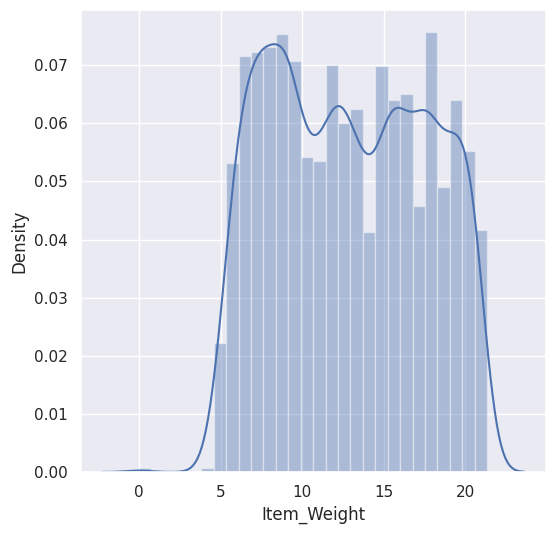

In [22]:
plt.figure(figsize=(6,6))
sns.distplot(df['Item_Weight'])
plt.show()


In [23]:
print(df['Item_Weight'])

0        9.300
1        5.920
2       17.500
3       19.200
4        8.930
         ...  
8518     6.865
8519     8.380
8520    10.600
8521     7.210
8522    14.800
Name: Item_Weight, Length: 8523, dtype: float64


/tmp/ipykernel_20/2345102419.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_Visibility'])


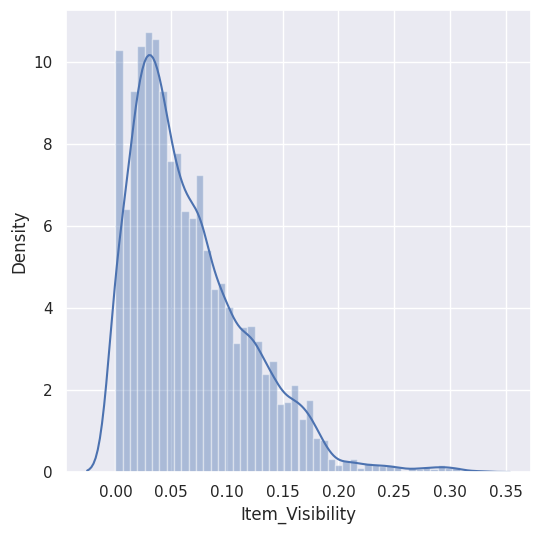

In [24]:
plt.figure(figsize=(6,6))
sns.distplot(df['Item_Visibility'])
plt.show()

/tmp/ipykernel_20/863441351.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_MRP'])


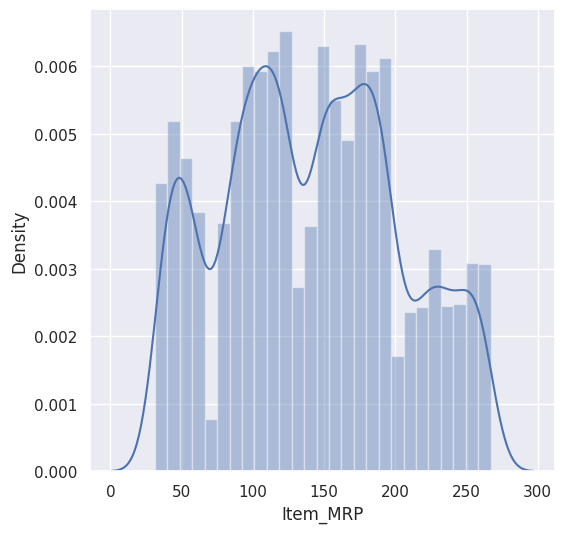

In [25]:
plt.figure(figsize=(6,6))
sns.distplot(df['Item_MRP'])
plt.show()

/tmp/ipykernel_20/616535255.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_Outlet_Sales'])


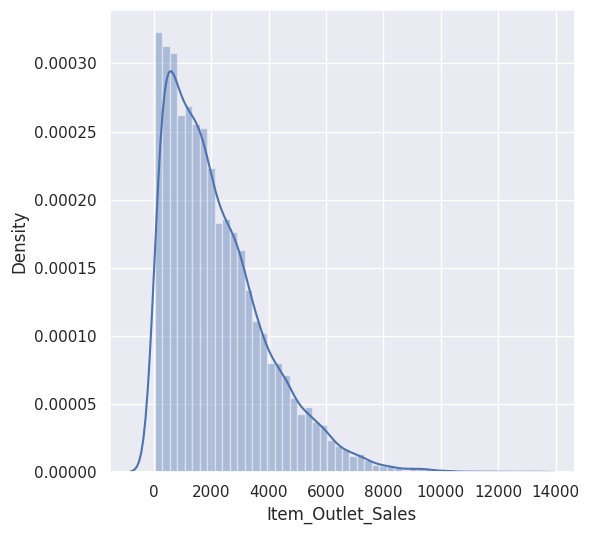

In [26]:
plt.figure(figsize=(6,6))
sns.distplot(df['Item_Outlet_Sales'])
plt.show()

/tmp/ipykernel_20/616535255.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_Outlet_Sales'])


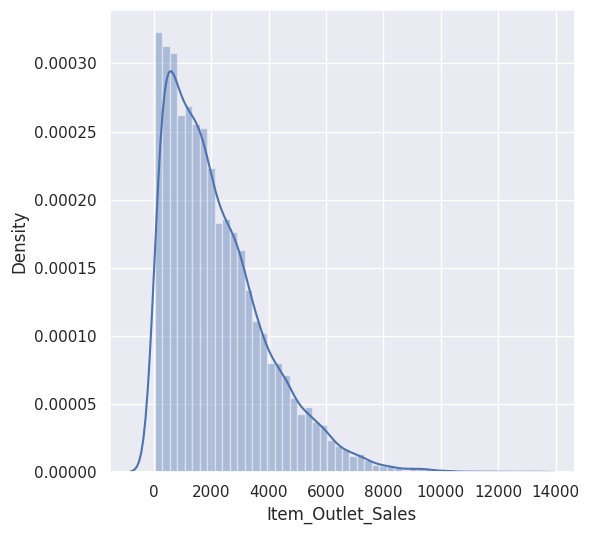

In [27]:
plt.figure(figsize=(6,6))
sns.distplot(df['Item_Outlet_Sales'])
plt.show()

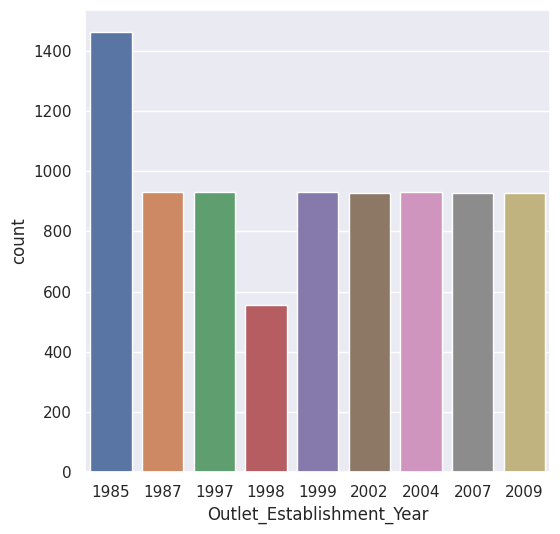

In [28]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year',data=df)
plt.show()

In [29]:
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [30]:
df.replace({'Item_Fat_Content':{'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'}},inplace=True)

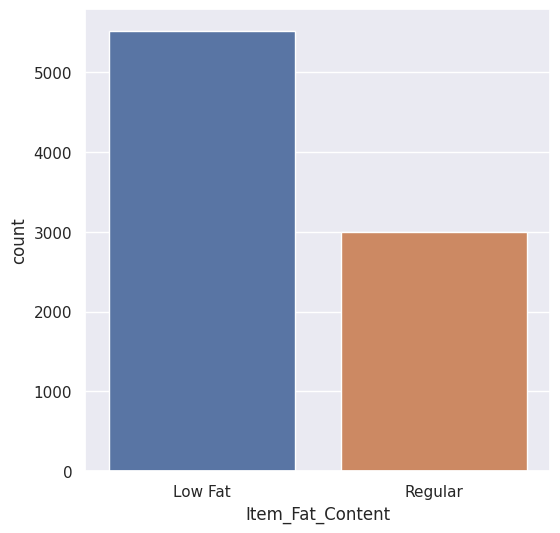

In [31]:
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content',data=df)
plt.show()

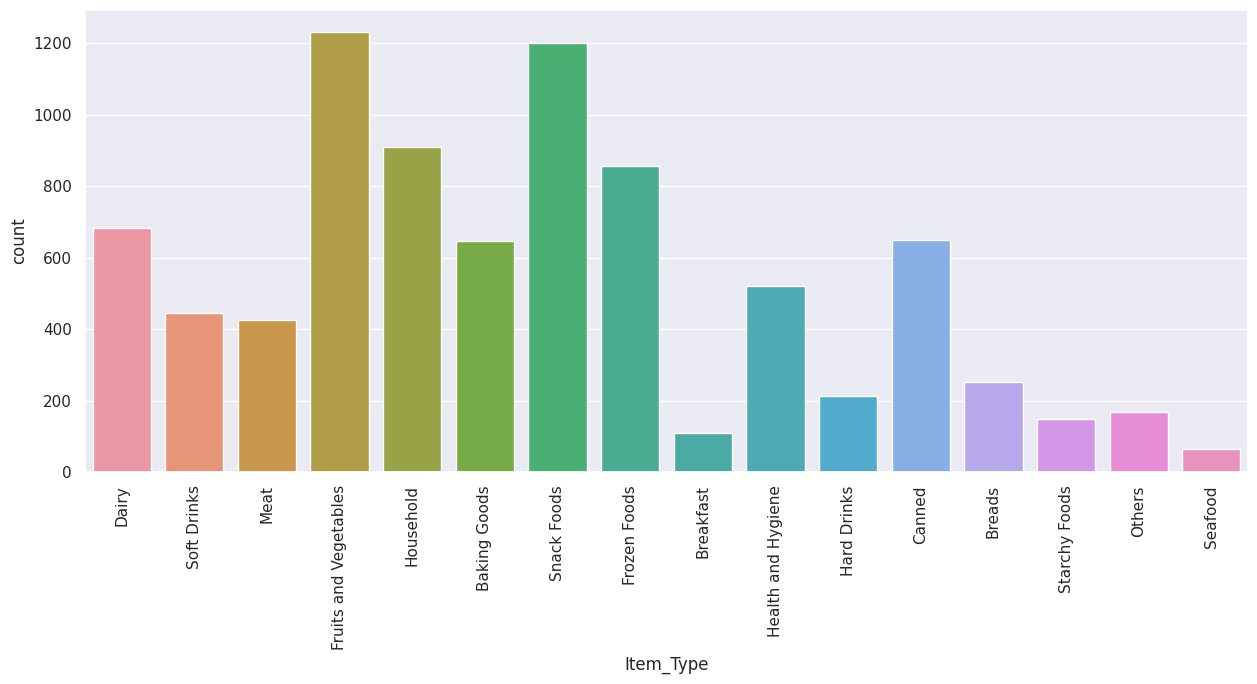

In [32]:
plt.figure(figsize=(15,6))
l=list(df['Item_Type'].unique())
fig=sns.countplot(x='Item_Type',data=df)
fig.set_xticklabels(labels=l,rotation=90)
plt.show()

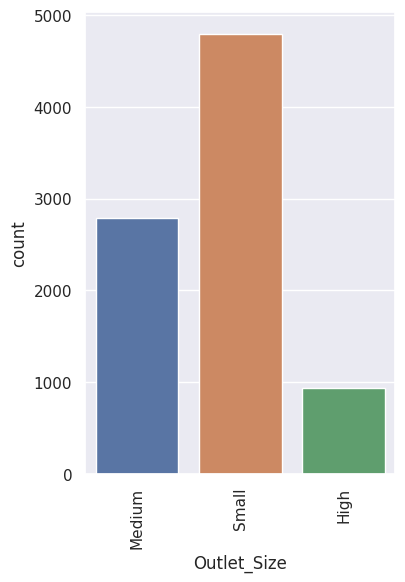

In [33]:
plt.figure(figsize=(4,6))
l=list(df['Outlet_Size'].unique())
fig=sns.countplot(x='Outlet_Size',data=df)
fig.set_xticklabels(labels=l,rotation=90)
plt.show()

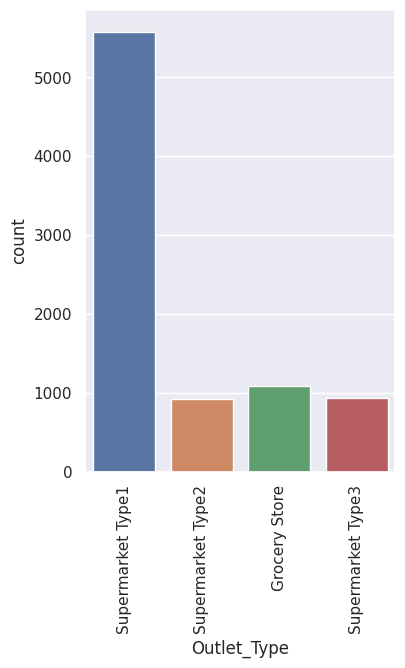

In [34]:
plt.figure(figsize=(4,6))
l=list(df['Outlet_Type'].unique())
fig=sns.countplot(x='Outlet_Type',data=df)
fig.set_xticklabels(labels=l,rotation=90)
plt.show()

In [35]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [36]:
encoder=LabelEncoder()

In [37]:
df['Item_Identifier']=encoder.fit_transform(df['Item_Identifier'])
df['Item_Fat_Content']=encoder.fit_transform(df['Item_Fat_Content'])
df['Item_Type']=encoder.fit_transform(df['Item_Type'])
df['Outlet_Identifier']=encoder.fit_transform(df['Outlet_Identifier'])
df['Outlet_Size']=encoder.fit_transform(df['Outlet_Size'])
df['Outlet_Location_Type']=encoder.fit_transform(df['Outlet_Location_Type'])
df['Outlet_Type']=encoder.fit_transform(df['Outlet_Type'])
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [38]:
x=df.drop('Item_Outlet_Sales',axis=1)
y=df['Item_Outlet_Sales']

In [39]:
print(x)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [40]:
print(y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


In [41]:
ss=StandardScaler()
x=ss.fit_transform(x)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=15)

In [43]:
model=XGBRegressor()


In [44]:
model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
y_train_predicted=model.predict(x_train)

In [46]:
y_test_predicted=model.predict(x_test)

In [47]:
r_squared = model.score(x_test, y_test)
r_squared

0.5325164279856744

In [48]:
from sklearn.metrics import r2_score
print('R2 Score: ', r2_score(y_test,y_test_predicted))

R2 Score:  0.5325164279856744
